Trial 5 Complete [00h 04m 07s]
val_accuracy: 0.8615535497665405

Best val_accuracy So Far: 0.8615535497665405
Total elapsed time: 00h 22m 38s

Pencarian Selesai! Parameter Terbaik:
- LSTM Units: 128
- Spatial Dropout: 0.4
- Dense Units: 64
- Dropout Rate: 0.2
- Learning Rate: 0.01

>>> [6/7] Training Final Model with Best Params...
Epoch 1/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 44s 153ms/step - accuracy: 0.4583 - loss: 1.2972 - val_accuracy: 0.8201 - val_loss: 0.5534
Epoch 2/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 37s 143ms/step - accuracy: 0.8343 - loss: 0.4387 - val_accuracy: 0.8584 - val_loss: 0.4202
Epoch 3/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 36s 141ms/step - accuracy: 0.8905 - loss: 0.2789 - val_accuracy: 0.8542 - val_loss: 0.4568
Epoch 4/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 36s 141ms/step - accuracy: 0.9183 - loss: 0.2071 - val_accuracy: 0.8491 - val_loss: 0.5117
Epoch 5/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 36s 141ms/step - accuracy: 0.9298 - loss: 0.1903 - val_accuracy: 0.8476 - val_loss: 0.5232
Epoch 6/25


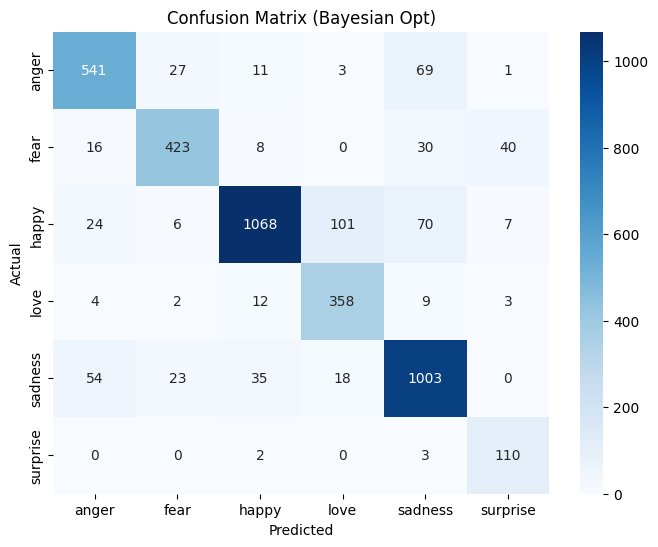

In [9]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt # Wajib install: pip install keras-tuner

# ==========================================
# 1. SETUP & LOAD DATA
# ==========================================
print(">>> [1/7] Setup Path & Loading Data...")

try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    BASE_DIR = os.getcwd()

POSSIBLE_DATA_DIR = os.path.join(BASE_DIR, 'data')
DATA_DIR = POSSIBLE_DATA_DIR if os.path.exists(POSSIBLE_DATA_DIR) else BASE_DIR

def get_path(filename):
    return os.path.join(DATA_DIR, filename)

try:
    # Menggunakan Dataset Campuran (Mixed) karena performanya terbukti paling stabil (83%)
    df_id = pd.read_csv(get_path('Twitter_Emotion_Dataset.csv'))
    df_en = pd.read_csv(get_path('train.txt'), sep=';', header=None, names=['tweet', 'label'])
    df_kamus = pd.read_csv(get_path('kamus_singkatan.csv'), sep=';', header=None, names=['slang', 'formal'])
    
    slang_dict = dict(zip(df_kamus['slang'], df_kamus['formal']))
    print("Files loaded successfully.")

except Exception as e:
    print(f"[ERROR] {e}")
    exit()

# ==========================================
# 2. PREPROCESSING
# ==========================================
print(">>> [2/7] Preprocessing...")

def clean_text_id(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text) 
    words = text.split()
    words = [slang_dict.get(w, w) for w in words]
    return ' '.join(words)

def clean_text_en(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    return ' '.join(text.split())

df_id['tweet_clean'] = df_id['tweet'].apply(clean_text_id)
df_en['tweet_clean'] = df_en['tweet'].apply(clean_text_en)

label_mapping = {'joy': 'happy'}
df_en['label'] = df_en['label'].replace(label_mapping)

df_combined = pd.concat([df_id[['tweet_clean', 'label']], df_en[['tweet_clean', 'label']]], ignore_index=True)

# ==========================================
# 3. TOKENIZATION
# ==========================================
print(">>> [3/7] Tokenization...")

MAX_NB_WORDS = 20000    
MAX_SEQUENCE_LENGTH = 100 
EMBEDDING_DIM = 100     

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_combined['tweet_clean'].values)
X = tokenizer.texts_to_sequences(df_combined['tweet_clean'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

le = LabelEncoder()
Y = le.fit_transform(df_combined['label'])
Y = pd.get_dummies(Y).values
LABELS = le.classes_

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=np.argmax(Y, axis=1)
)

# ==========================================
# 4. DEFINE HYPERMODEL (Untuk Tuning)
# ==========================================
print(">>> [4/7] Setting up Bayesian Optimization...")

def build_model(hp):
    model = Sequential()
    
    # 1. Tuning Embedding Dimensi (Optional, tapi kita fix 100 biar tidak terlalu berat)
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    
    # 2. Tuning Spatial Dropout (Range 0.2 - 0.5)
    model.add(SpatialDropout1D(hp.Float('spatial_dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # 3. Tuning LSTM Units (Range 32 - 128)
    # Kita minta Tuner memilih antara 32, 64, atau 128 neuron
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    model.add(Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.0)))
    
    # 4. Tuning Dense Layer
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=64, step=32), activation='relu'))
    
    # 5. Tuning Dropout Rate (Range 0.2 - 0.5)
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(len(LABELS), activation='softmax'))
    
    # 6. Tuning Learning Rate (Pilih antara 1e-2, 1e-3, 1e-4)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Setup Tuner: BayesianOptimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy', # Target yang ingin dimaksimalkan
    max_trials=5,             # Jumlah percobaan kombinasi (Jangan terlalu banyak nanti lama)
    executions_per_trial=1,   # Berapa kali run tiap kombinasi
    directory='my_tuning_dir',
    project_name='emotion_lstm_tuning'
)

# ==========================================
# 5. RUN SEARCH (Mencari Parameter Terbaik)
# ==========================================
print(">>> [5/7] Searching Best Hyperparameters (Ini butuh waktu)...")

early_stop_search = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train, Y_train, 
             epochs=10, # Epoch pendek saja untuk screening
             validation_data=(X_test, Y_test),
             callbacks=[early_stop_search])

# Ambil Parameter Terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Pencarian Selesai! Parameter Terbaik:
- LSTM Units: {best_hps.get('lstm_units')}
- Spatial Dropout: {best_hps.get('spatial_dropout')}
- Dense Units: {best_hps.get('dense_units')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# ==========================================
# 6. TRAIN FINAL MODEL (Pakai Parameter Juara)
# ==========================================
print(">>> [6/7] Training Final Model with Best Params...")

# Build model dengan parameter terbaik
model = tuner.hypermodel.build(best_hps)

# Hitung Class Weight
class_weights_val = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_combined['label']),
    y=df_combined['label']
)
weights_dict = dict(enumerate(class_weights_val))

# Early Stopping Final
early_stop_final = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, Y_train,
    epochs=25, 
    batch_size=64,
    validation_data=(X_test, Y_test),
    callbacks=[early_stop_final],
    class_weight=weights_dict,
    verbose=1
)

# ==========================================
# 7. EVALUATION
# ==========================================
print(">>> [7/7] Evaluation...")

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(Y_true, Y_pred_classes, target_names=LABELS))

plt.figure(figsize=(8,6))
cm = confusion_matrix(Y_true, Y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title('Confusion Matrix (Bayesian Opt)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [10]:
import pickle
from tensorflow.keras.models import save_model

# 1. Simpan Model Keras (.h5)
model_path = 'model_emosi_lstm.h5'
model.save(model_path)
print(f"Model berhasil disimpan di: {model_path}")

# 2. Simpan Tokenizer (.pickle)
# WAJIB: Web perlu tahu cara mengubah kata "aku" jadi angka "45" yang sama persis dengan saat training
tokenizer_path = 'tokenizer_emosi.pickle'
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Tokenizer berhasil disimpan di: {tokenizer_path}")

# 3. Simpan Label Encoder (.pickle)
# Agar web tahu angka 0 itu "Anger" atau "Happy"
le_path = 'label_encoder.pickle'
with open(le_path, 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Label Encoder berhasil disimpan di: {le_path}")

Model berhasil disimpan di: model_emosi_lstm.h5
Tokenizer berhasil disimpan di: tokenizer_emosi.pickle
Label Encoder berhasil disimpan di: label_encoder.pickle
